In [4]:
#Dependencies

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import linregress


## Data Import and Clean

In [9]:
#crime statistics data
file = "datasource/WA Police Force Crime Timeseries.xlsx"
WAstats = pd.read_excel(file,sheet_name = "Data")
#fillna with 0 for 0 crime counts
WAstats.fillna(0, inplace = True)

In [10]:
#estimated resident population data
erpfile = "datasource/ERP.xls"
erp = pd.read_excel(erpfile,sheet_name = "Sheet1", header=2)
#drop nas for blank years
erp.dropna(inplace = True)
#change year column to datetime format
erp['Year (ending June 30)'] = pd.to_datetime(erp['Year (ending June 30)'], format='%Y')

In [11]:
#get dv related homeless services provided
sasfile = "datasource/sasexport.xlsx"
dvhomeless = pd.read_excel(sasfile,sheet_name = "Sheet1",header=3)
#fill in state data downwards
dvhomeless.fillna(method='ffill', inplace=True)

In [62]:
#get google search trends on domestic violence
googlefile = "datasource/wadvsearch.csv"
dvgoogle = pd.read_csv(googlefile, header = 1)
dvgoogle['Month/Year'] = pd.to_datetime(dvgoogle['Week'], dayfirst=True).dt.to_period('M')
dvgooglemonthly = dvgoogle.groupby('Month/Year')['Domestic violence: (Western Australia)'].sum().reset_index()


googlerespectfile = "datasource/1800respect.csv"
respectsearch = pd.read_csv(googlerespectfile, header = 2)
respectsearch['Month/Year'] = pd.to_datetime(respectsearch['Week'], dayfirst=True).dt.to_period('M')
respectmonthly = respectsearch.groupby('Month/Year')['1800 respect: (Australia)'].sum().reset_index()


In [27]:
#population df manually created from website query data
population = {'Website Region' : ['Goldfields-Esperance District', 'Great Southern District',
        'Kimberley District',
       'Metropolitan Region', 'Mid West-Gascoyne District',
       'Pilbara District', 'South West District', 'Wheatbelt District','Western Australia'],
    'Population': [54363, 60993,35901,1900000, 62932,62093, 179791, 73437,2663561]}
pop_df = pd.DataFrame(population)

In [ ]:
#list of regions
regionlist = WAstats['Website Region'].unique()
regionlist

In [ ]:
#list of crimes lvl2
basiccrimedesc = WAstats['WAPOL_Hierarchy_Lvl2'].unique()
basiccrimedesc

In [28]:
#All WA stats from 2019
WAstats2019 = WAstats[WAstats["Period"]>dt.datetime(year=2019, month = 1, day = 1)]


In [24]:
#key crimes list
TopCrimes = WAstats.groupby('WAPOL_Hierarchy_Lvl2')["COUNT_of_Offnc_ID"].sum().sort_values(ascending = False)
keycrimes = TopCrimes[0:6].index.tolist()
keycrimes

['Stealing',
 'Property Damage',
 'Burglary',
 'Drug Offences',
 'Fraud & Related Offences',
 'Assault (Family)']

In [29]:
#grouped into region, time period and Lvl 2 crime
Grouped = WAstats.groupby(['Website Region','Period','WAPOL_Hierarchy_Lvl2'])['COUNT_of_Offnc_ID'].sum().reset_index()
#merge with population 
GroupedRates = pd.merge(Grouped, pop_df,on='Website Region')
#calculate crime rate
GroupedRates['Rate'] = GroupedRates['COUNT_of_Offnc_ID']/(GroupedRates['Population'])*100000
#preview dataframe
GroupedRates.head()

,Website Region,Period,WAPOL_Hierarchy_Lvl2,COUNT_of_Offnc_ID,Population,Rate
0,Goldfields-Esperance District,2007-01-01,Arson,5.0,54363,9.197432
1,Goldfields-Esperance District,2007-01-01,Assault (Family),63.0,54363,115.887644
2,Goldfields-Esperance District,2007-01-01,Assault (Non-Family),71.0,54363,130.603535
3,Goldfields-Esperance District,2007-01-01,Breach of Violence Restraint Order,14.0,54363,25.752810
4,Goldfields-Esperance District,2007-01-01,Burglary,168.0,54363,309.033718


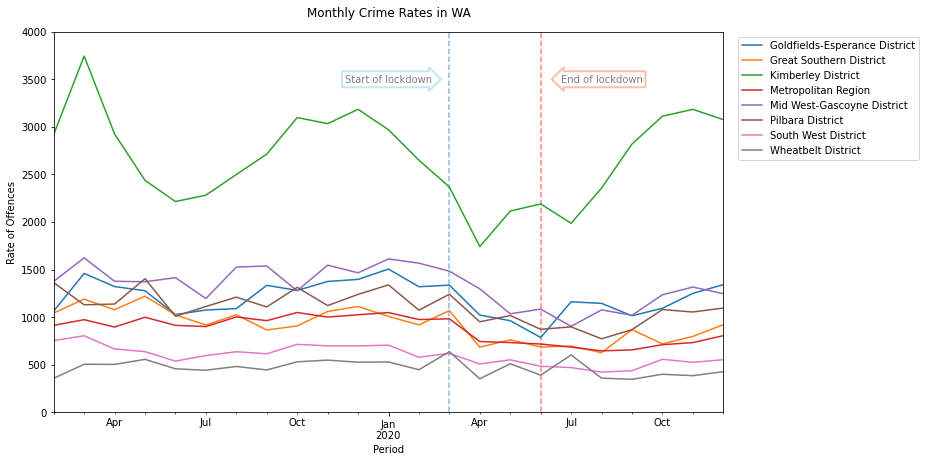

In [31]:
#get total crime rate per region from 2019
From2019 = GroupedRates[GroupedRates["Period"]>dt.datetime(year=2019, month = 1, day = 1)]
TotalCrimeRate = From2019.groupby(['Website Region','Period'])['Rate'].sum().reset_index()
RegionalCrimeRate = TotalCrimeRate[(TotalCrimeRate['Website Region']!='Western Australia')]
#pivot for graphing
TotalCrimesPivot = RegionalCrimeRate.pivot(index='Period', columns='Website Region', values='Rate')
#make chart
TotalCrimesPivot.plot(figsize=(12,7))
plt.legend(bbox_to_anchor = (1.3, 1.0))
plt.text(
    "2020-01", 3500, "Start of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="skyblue", alpha=0.5, lw=2))
plt.text(
    "2020-08", 3500, "End of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="coral", alpha=0.5, lw=2))
plt.vlines("2020-03",ymin = 0, ymax = 4000,linestyles='dashed', alpha=0.5)
plt.vlines("2020-06",ymin = 0, ymax = 4000, colors ="red",linestyles='dashed', alpha=0.5)
plt.ylim(0,4000)
plt.title("Monthly Crime Rates in WA", pad=15)
plt.ylabel("Rate of Offences")
plt.savefig("output/crimeratesregions.png",bbox_inches='tight')
plt.show()

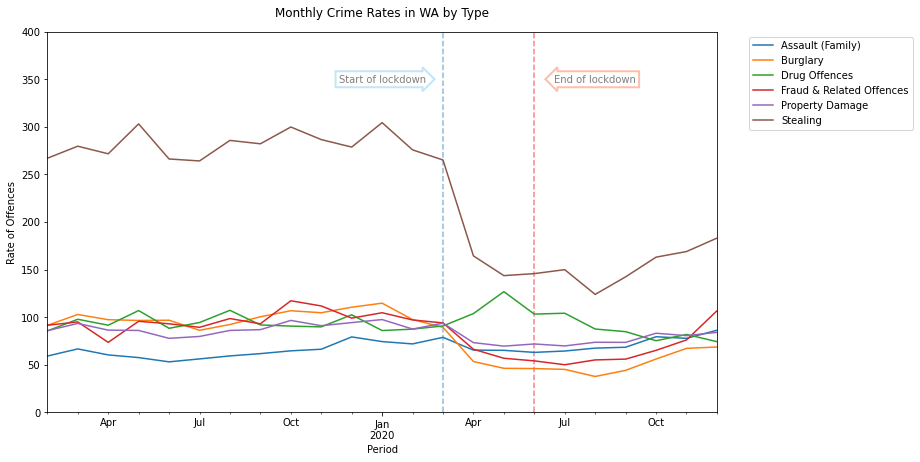

In [124]:
#get rates of key crimes
WARate = From2019[From2019['Website Region']=='Western Australia']
CrimeTypeRate = WARate[WARate['WAPOL_Hierarchy_Lvl2'].isin(keycrimes)]
CrimeTypeRate = CrimeTypeRate.groupby(['WAPOL_Hierarchy_Lvl2','Period'])['Rate'].sum().reset_index()
#pivot for graphing
CrimesPivot = CrimeTypeRate.pivot(index='Period', columns='WAPOL_Hierarchy_Lvl2', values='Rate')
#make chart
CrimesPivot.plot(figsize=(12,7))
plt.legend(bbox_to_anchor = (1.3, 1.0))
plt.text(
    "2020-01", 350, "Start of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="skyblue", alpha=0.5, lw=2))
plt.text(
    "2020-08", 350, "End of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="coral", alpha=0.5, lw=2))
plt.vlines("2020-03",ymin = 0, ymax = 500,linestyles='dashed', alpha=0.5)
plt.vlines("2020-06",ymin = 0, ymax = 500, colors ="red",linestyles='dashed', alpha=0.5)
plt.ylim(0,400)
plt.title("Monthly Crime Rates in WA by Type", pad=15)
plt.ylabel("Rate of Offences")
plt.savefig("output/crimetyperatesregions.png",bbox_inches='tight')
plt.show()

In [46]:
#set time frames of pre, into and post lockdown
timeframes = TotalCrimeRate[(TotalCrimeRate['Period']=='2020-02')|(TotalCrimeRate['Period']=='2020-05')|(TotalCrimeRate['Period']=='2020-07')]
timeframes = timeframes[["Website Region",'Period','Rate']]
timeframes.head()


,Website Region,Period,Rate
12,Goldfields-Esperance District,2020-02-01,1318.911760
15,Goldfields-Esperance District,2020-05-01,962.051395
17,Goldfields-Esperance District,2020-07-01,1160.715928
35,Great Southern District,2020-02-01,918.138147
38,Great Southern District,2020-05-01,760.743036


In [47]:
#get percentage change
overallchange = timeframes.set_index(["Website Region",'Period']).pct_change().multiply(100).round(2)


In [48]:
#get data into separate tables for map plotting
overallchange.reset_index(inplace=True)
Regionsinto = overallchange[overallchange['Period']=='2020-05-01']
Regionsout = overallchange[overallchange['Period']=='2020-07-01']
Regionsinto.to_csv("Regionsinto.csv", encoding = "utf-8", index=False)
Regionsout.to_csv("Regionsout.csv", encoding = "utf-8", index=False)

In [57]:
#get domestic violence data per region
Domesticviolence = GroupedRates[((GroupedRates["WAPOL_Hierarchy_Lvl2"]=="Assault (Family)")|(GroupedRates["WAPOL_Hierarchy_Lvl2"]=="Threatening Behaviour (Family)"))] 
Domesticviolence = Domesticviolence.replace({'Assault (Family)':'Domestic Violence','Threatening Behaviour (Family)':'Domestic Violence'})
Domesticviolence = Domesticviolence.groupby(["Website Region",'Period','WAPOL_Hierarchy_Lvl2'])['Rate'].sum().reset_index()
Domesticviolencecovid = Domesticviolence[((Domesticviolence["Period"]=="2020-02")|(Domesticviolence["Period"]=="2020-05")|(Domesticviolence["Period"]=="2020-07"))]


In [50]:
Domesticviolencecovid.head()

,Website Region,Period,WAPOL_Hierarchy_Lvl2,Rate
157,Goldfields-Esperance District,2020-02-01,Domestic Violence,172.911723
160,Goldfields-Esperance District,2020-05-01,Domestic Violence,185.788128
162,Goldfields-Esperance District,2020-07-01,Domestic Violence,204.182992
325,Great Southern District,2020-02-01,Domestic Violence,113.127736
328,Great Southern District,2020-05-01,Domestic Violence,108.209139


In [51]:
#get % change in dv between time periods
Domesticviolencechange = Domesticviolencecovid.drop(columns="WAPOL_Hierarchy_Lvl2").set_index(["Website Region",'Period']).pct_change().multiply(100).round(2)

In [52]:
Domesticviolencechange.reset_index(inplace=True)

In [53]:
Regionsdvin = Domesticviolencechange[Domesticviolencechange['Period']=='2020-05']
Regionsdvout = Domesticviolencechange[Domesticviolencechange['Period']=='2020-07']

In [54]:
#save to csv for map plot
Regionsdvin.to_csv("output/Regionsdvinto.csv", encoding = "utf-8", index=False)
Regionsdvout.to_csv("output/Regionsdvout.csv", encoding = "utf-8", index=False)

In [66]:
#pivot for graphing
Domesticviolence2019 = Domesticviolence[Domesticviolence["Period"]>dt.datetime(year=2019, month = 1, day = 1)]
DomesticviolenceRegion = Domesticviolence2019[Domesticviolence2019['Website Region']!='Western Australia']
DVpivot = DomesticviolenceRegion.drop(columns=["WAPOL_Hierarchy_Lvl2"]).pivot(index='Period', columns='Website Region', values='Rate')

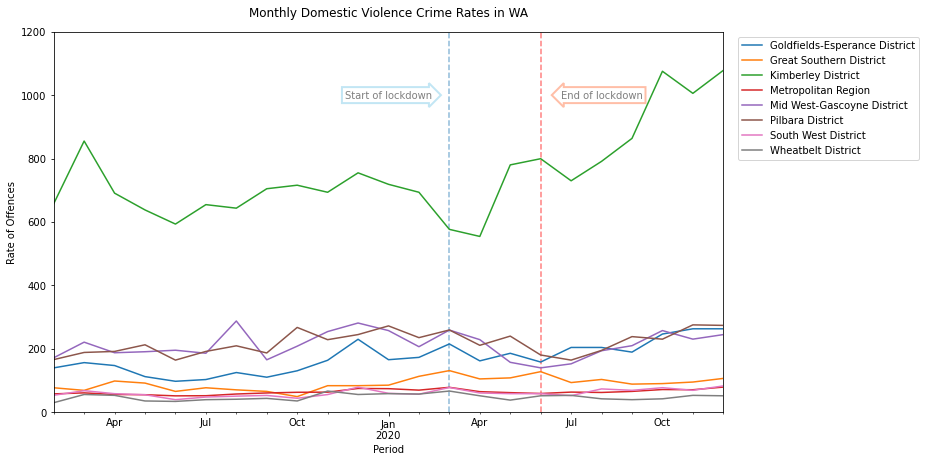

In [67]:
#plot dv chart
DVpivot.plot(figsize=(12,7))
plt.legend(bbox_to_anchor = (1.3, 1.0))
plt.text(
    "2020-01", 1000, "Start of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="skyblue", alpha=0.5, lw=2))
plt.text(
    "2020-08", 1000, "End of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="coral", alpha=0.5, lw=2))
plt.vlines("2020-03",ymin = 0, ymax = 1200,linestyles='dashed', alpha=0.5)
plt.vlines("2020-06",ymin = 0, ymax = 1200, colors ="red",linestyles='dashed', alpha=0.5)
plt.ylim(0,1200)
plt.title("Monthly Domestic Violence Crime Rates in WA", pad=15)
plt.ylabel("Rate of Offences")
plt.savefig("output/dvratesregions.png",bbox_inches='tight')
plt.show()

In [86]:
DomesticviolenceWA = Domesticviolence[Domesticviolence['Website Region']=='Western Australia']

In [87]:
dvsearches = pd.merge(DomesticviolenceWA,dvgooglemonthly, how='inner', left_on = DomesticviolenceWA['Period'].dt.strftime('%Y-%m'),right_on = dvgooglemonthly['Month/Year'].dt.strftime('%Y-%m'))
allsearches = pd.merge(dvsearches,respectmonthly, on= 'Month/Year')
allsearches.rename(columns ={'Rate':'Domestic Violence Offences','Domestic violence: (Western Australia)':'Google Searches for domestic violence in Western Australia','1800 respect: (Australia)':'Google Searches for 1800 respect in Australia'}, inplace=True)
allsearches2019 = allsearches[allsearches["Period"]>dt.datetime(year=2019, month = 1, day = 1)]

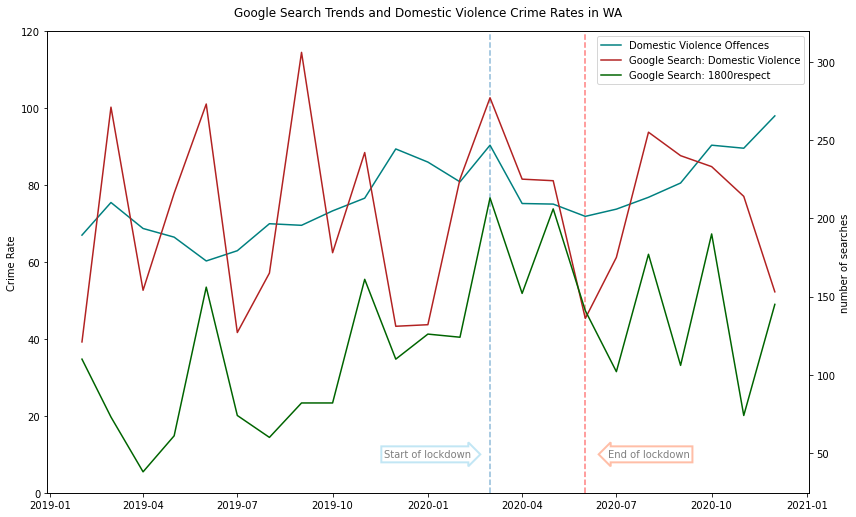

In [88]:
fig, ax1 = plt.subplots(figsize=(12,7))


ax1.set_ylabel('Crime Rate')
ax1.plot(allsearches2019['Period'], allsearches2019['Domestic Violence Offences'],label = 'Domestic Violence Offences',color='teal')


ax2 = ax1.twinx() 

ax2.set_ylabel('number of searches')  
ax2.plot(allsearches2019['Period'], allsearches2019['Google Searches for domestic violence in Western Australia'],label = 'Google Search: Domestic Violence',color ='firebrick')
ax2.plot(allsearches2019['Period'], allsearches2019['Google Searches for 1800 respect in Australia'],label = 'Google Search: 1800respect',color ='darkgreen')

ax1.text(
    dt.datetime(year=2020, month = 1,day=1), 10, "Start of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="skyblue", alpha=0.5, lw=2))
ax1.text(
    dt.datetime(year=2020, month = 8,day=1), 10, "End of lockdown", alpha =0.5,ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="coral", alpha=0.5, lw=2))
ax1.vlines(dt.datetime(year=2020, month = 3,day=1),ymin = 0, ymax = 150,linestyles='dashed', alpha=0.5)
ax1.vlines(dt.datetime(year=2020, month = 6,day=1),ymin = 0, ymax = 150, colors ="red",linestyles='dashed', alpha=0.5)
ax1.set_ylim(0,120)
fig.tight_layout() 
plt.title('Google Search Trends and Domestic Violence Crime Rates in WA', pad=15)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax1.legend(lines, labels, loc=0)
plt.savefig("output/googlesearchtrends.png",bbox_inches='tight')
plt.show()

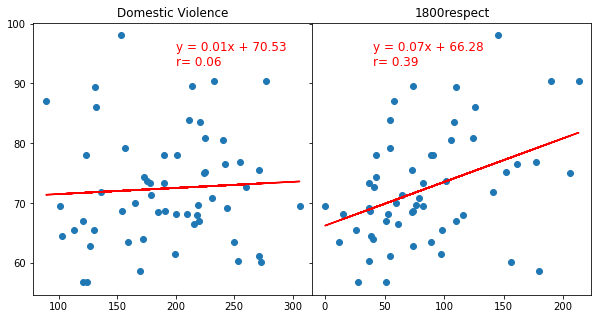

In [122]:
a=allsearches['Google Searches for domestic violence in Western Australia']
b=allsearches['Domestic Violence Offences']
c=allsearches['Google Searches for 1800 respect in Australia']

(aslope, aintercept, arvalue, apvalue, astderr) = linregress(a, b)
aregress_values = a * aslope + aintercept
aline_eq = "y = " + str(round(aslope,2)) + "x + " + str(round(aintercept,2))
(cslope, cintercept, crvalue, cpvalue, cstderr) = linregress(c, b)
cregress_values = c * cslope + cintercept
cline_eq = "y = " + str(round(cslope,2)) + "x + " + str(round(cintercept,2))

# plt.plot(a,regress_values,"r-")
# plt.annotate(f"{line_eq}\nr= {rvalue:.2f}",(200,92),fontsize=12,color="red")
# plt.title("Monthly Domestic Violence Crime Rates in WA", pad=15)
# plt.ylabel("Rate of Offences")

# plt.show()
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(10, 5)
ax1.scatter(a, b)
ax1.plot(a,aregress_values,'-r')
ax1.set_title('Domestic Violence')
ax1.annotate(f"{aline_eq}\nr= {arvalue:.2f}",(200,93),fontsize=12,color="red")
ax2.scatter(c, b)
ax2.plot(c,cregress_values,'-r')
ax2.set_title('1800respect')
ax2.annotate(f"{cline_eq}\nr= {crvalue:.2f}",(40,93),fontsize=12,color="red")
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("output/searchregressions.png",bbox_inches='tight')
plt.show()

In [24]:
#get only WA data
WAhomeless = dvhomeless[dvhomeless['State or territory of agency']=='WA']

In [25]:
WAhomeless = WAhomeless.drop(columns=['State or territory of agency'])

In [26]:
#sum male and female 
WAhomelesstotal = WAhomeless.groupby('Financial year')['Client count'].sum()

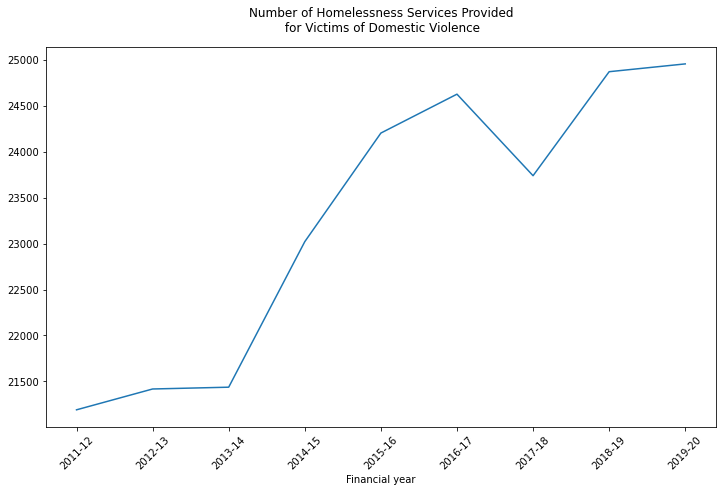

In [94]:
#plot number of services provided
WAhomelesstotal.plot(figsize=(12,7))
plt.xticks(rotation=45)
plt.title('Number of Homelessness Services Provided\n for Victims of Domestic Violence', pad = 15)
plt.show()